#### Ce code traite le problème d'estimation de prix de maisons

La première partie est consacrée au data cleaning/transformation de données 
Les données numériques manquantes ont été remplacées par la valeur la plus courante dans la colonne
Les variables numériques qui
Quelques features engineering ont été effectués sur la dataset notamment via la fonction select_features
Enfin, une fonction train_and_test calcule le rmse


### @ssjss77 le 05/08/2020

In [17]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 
from scipy.stats import norm, skew
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

pd.set_option('display.max_columns', 500)



def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

In [12]:
def transform_features(df, percent_missing=0.05):


    num_missing = df.isnull().sum()
    # Filtrer l'objet Series sur les colonnes contenant > percent_missing% de valeurs manquantes


    drop_missing_cols = num_missing[(num_missing > len(df)*percent_missing)].sort_values()
    
    # Supprimer ces colonnes dans le DataFrame


    df = df.drop(drop_missing_cols.index, axis=1)
    
    

    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(
        ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    # Calculer le nombre de valeurs numérique manquantes colonne par colonne 
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)*percent_missing) & 
                                       (num_missing > 0)].sort_values()
    
    # Calculer la valeur la plus commune pour chaque colonne

    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(
        orient='records')[0]
    
    # Remplacer les valeurs manquantes
    df = df.fillna(replacement_values_dict)
    
    #Quelques simplifications
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    #Supprimer les lignes ayant des années négatives
    df = df.drop([1702, 2180, 2181], axis=0)
    # Supprimer les colonnes inutiles/qui font fuiter des informations sur la vente finale

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", 
                  "Year Remod/Add"], axis=1)
    
    return df



In [13]:
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    
    numerical_df = df.select_dtypes(include=['int', 'float'])
    #Calculer la matrice de corrélation
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    #Ne gardons que les colonnes avec un coefficient de corrélation supérieur à 0.4 
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    # Créer une liste de noms de colonne à partir du fichier .txt qui sont censés être 
    # catégoriques
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour",
                        "Lot Config", "Neighborhood", "Condition 1", "Condition 2", 
                        "Bldg Type", "House Style", "Roof Style", "Roof Matl","Exterior 1st",
                        "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", 
                        "Central Air", "Garage Type","Misc Feature", "Sale Type", 
                        "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)
            
            
    #inutile d'avoir une colonne avec beacoup de valeurs, donc on cherche les valeurs uniques dans chaque colonnes
    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    # Limite arbitraire de 10 valeurs uniques et supprimer les colonnes ne respectant pas cette condition
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > uniq_threshold].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    # Sélectionner uniquement les colonnes de texte restantes et convertissez-les en catégories
    text_cols = df.select_dtypes(include=['object'])
    
    # Créer des colonnes factices et ajouter les au DataFrame
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
    
    return df

In [15]:
def train_and_test(df, k):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    #Cas simple : On entraine les données [Train] et on fait des prédictions sur Test
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)
        
        return rmse
    
    #Cas 2 : On entraine les données [Train et Test] et on fait des prédictions sur [Test et Train]
    if k == 1:
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])
        
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        
        return avg_rmse
    
    #Cas 3 : Cross validation
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        
        return avg_rmse

In [14]:
#exploration de données : 


data = pd.read_csv("AmesHousing.tsv", delimiter='\t')
data.head(4)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
734,735,903226170,50,RM,50.0,6000,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,134900


In [10]:
data.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [7]:
#Analyser le contenue du jeu de données 

print(data.shape)
print(len(str(data.shape))*'-')
print(data.dtypes.value_counts())
data.head()

(2930, 82)
----------
object     43
int64      28
float64    11
dtype: int64


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


33367.28718340371
27155.13848482536
[31762.88165712173, 27989.640885047782]
[27246.722109273804, 23171.22069656787, 35185.12370813308]
[36169.83527995952, 28330.806682597475, 24765.514120894575, 26181.054165812555]
[27447.841676984313, 37359.29133658523, 28818.72309786088, 26712.40190340381, 25284.240779406184]
[25358.503353675766, 25427.75248032289, 26636.373117635092, 23902.223214691963, 27380.785930582217, 41673.848443144634]
[29168.934166924388, 26160.875337574023, 23502.32137341532, 27815.609648744197, 28384.638499997327, 22756.609570434583, 43690.28919009526]
[25743.089237262382, 24340.537178600112, 28332.057846352953, 23487.039424864008, 44570.733514127685, 28910.391128268755, 27444.41463431181, 26493.46559353241]
[27431.987074184395, 22625.880226087207, 48152.86105829192, 25736.909429406503, 25732.501312514472, 26532.088127072195, 26605.504418387078, 25043.080464401024, 26795.562021372214]
[47903.364935661695, 28080.397254294996, 29592.82637855066, 22187.315842459982, 27090.251

[28513.140849826636, 23722.615469831206, 24635.08699563855, 25251.004293030597, 32802.56402817367, 22121.67064785382, 25167.238241371942, 25507.529958091185, 31432.477670095115, 74574.52338988837, 30319.222884243627, 28842.605063238392, 25657.901319961766, 30285.087030554445, 23574.17585924621, 19261.453201086664, 24652.829181857192, 22240.734902146796, 29934.955274950218, 29077.80800016804, 25375.61486806792, 24332.32251577113, 23391.433415610176, 24919.490751215122, 26146.417453659386, 22933.67645209304, 32570.490302335264, 29018.94885201544, 20719.177167882845, 23995.478007048885]
[27250.093944571006, 25503.40013855962, 20213.249579776162, 31625.90792013944, 28272.397199482442, 22159.58986584779, 24592.426640365094, 37828.2655843941, 30703.4989534367, 26527.580759498112, 27917.579664983994, 21000.72858966774, 25523.45305887035, 19290.853099788637, 34759.44493895011, 23371.682585712202, 23715.953310347995, 29914.476923643535, 26419.35245508525, 27218.904496755724, 20400.225355055434,

[24142.685630606735, 84275.63246028859, 24677.148417025346, 23547.07962416837, 26892.538450432785, 36558.43719451947, 31326.54163613462, 23277.33645504862, 32324.595885398743, 29050.550064620613, 29163.300453351036, 29697.954741954367, 26799.463486702996, 20462.83832265175, 27452.828766314593, 32653.815035632662, 29486.856185389646, 35929.278557625265, 23918.189595886888, 19074.10810887872, 29401.918106416117, 24131.82727565925, 23298.8344897998, 31678.58487642931, 21876.326808873542, 23260.115846721685, 22148.349224007048, 24115.58486169482, 22090.303030466635, 24133.963768315174, 31597.16566954909, 20310.740043107842, 22542.888250805765, 24213.539891407538, 31863.80447067981, 23330.405000778075, 34605.678466208614, 19336.632135185646, 24195.459221945268, 22365.94359895947, 15166.247104842787, 27779.146145625462]
[19493.852094743397, 25224.58254366819, 26488.614139224006, 29632.542987943485, 33194.015445741265, 36166.52497078397, 23789.67421435351, 27758.56600703477, 19098.29054136666

[25262.19257797059, 30316.13356267276, 25663.58837572607, 32916.43420738102, 31546.903800246822, 21335.749807026245, 37777.19885904238, 20821.909006037542, 20763.163188795625, 24080.37154374295, 36510.07065772156, 25304.033435359088, 19087.699214562053, 20337.387376491926, 19734.021982901282, 30052.922368564712, 21709.191388085164, 23564.796836365316, 23077.575752166114, 23731.132180036922, 36360.169984132466, 22155.261804521768, 24500.33573543062, 21818.55642650728, 40691.270958708556, 22866.98930708095, 21817.217184360416, 31123.777707940182, 31504.832828809096, 21870.931128749708, 22851.07472746468, 18712.678785865326, 22556.679202390947, 24353.588443508805, 19875.697965851956, 30011.737776851583, 24261.019585157417, 26071.186380644504, 20787.091274080605, 26648.434512468848, 94494.14239047181, 21178.733535415824, 26334.486739869317, 23131.8680946951, 21298.328385222543, 24442.7144520744, 24109.28191715349, 27433.43569267124, 23634.21088597303, 45012.65756354012, 27710.152499782755,

[20011.51180604186, 29486.92694961736, 33753.13469612866, 24298.843035602415, 36303.13909193971, 34083.78089551922, 26522.530717267873, 28738.483957039196, 25137.402333140024, 19506.84308912949, 23949.599130646577, 25884.42381203821, 30890.93532582634, 27952.643446412494, 30309.739133240266, 31238.91070378241, 19646.759327551263, 27679.806720335015, 20779.682233979504, 30694.29297670768, 22442.67245769704, 24351.79418617115, 18375.891108227686, 18887.795274365646, 21271.173425727608, 22591.212273047844, 29374.178875674454, 38378.801917052304, 36954.53427320103, 31396.805053797947, 18318.975409057504, 21182.9502538252, 25795.64181319983, 20124.280388733387, 35555.692354682156, 28008.141606007113, 22054.754140971123, 18985.479345812164, 25793.55365535785, 28222.469558676738, 29604.02657736733, 34483.35619877585, 23363.458279373153, 24476.47978897498, 22769.164769927018, 20246.843029057814, 25884.638478279434, 22604.710969906813, 103778.24575605865, 31440.694451648553, 19005.012463648418,

[21582.949503889366, 18024.779717028316, 27094.941194617848, 22022.85488996716, 25167.45090458896, 24904.243812453842, 22263.54266497487, 20331.352701989254, 24597.15482841939, 16638.43083286474, 33487.36548957684, 26397.451009940844, 21299.670111760384, 30259.0367619677, 21347.346168492506, 38824.184599858374, 106427.45686943858, 27888.858855677958, 25339.057992051326, 26048.260285257285, 24382.21413977402, 15468.564715672308, 27685.8176170366, 29748.224215986596, 20460.60265577833, 34847.49440798498, 37137.83313797061, 19172.62719268448, 24050.60276531768, 28755.86841983518, 17783.23837269041, 26654.042019249406, 33113.637550496074, 19779.20238380134, 23617.597978268874, 26784.11331501333, 14378.298897447872, 19006.83629152531, 18987.74591471481, 23817.079934778114, 30412.749499029822, 19785.4790340695, 28209.963468096033, 37323.668892608395, 27839.53227370218, 21126.6305508513, 27016.18838108501, 23608.133364894158, 23599.04783572501, 27502.473406879304, 20752.546310360725, 25526.21

[19581.64135293747, 24734.427665308805, 25495.682103484043, 19627.650632696852, 31275.606579028285, 26024.59301216904, 24801.858154098507, 23695.750055646895, 24776.011880207767, 40372.29642445088, 24345.411822141854, 34390.57248070198, 22786.4524244198, 22201.17330732587, 30695.93410607441, 21753.71101046068, 27609.58132762454, 18641.747974076636, 36159.192941389825, 21827.258904314316, 30179.021369881433, 25612.57487950006, 21725.88661823024, 18689.213872594595, 31304.810021067777, 27846.94586050208, 23767.87147960286, 14725.432170716369, 23460.182443061465, 33994.53469225508, 24997.1556745061, 22480.286632699183, 20158.790340707055, 27545.310639960513, 16274.849850412864, 20483.840301711767, 32448.504335198762, 26469.210952238253, 21600.485023540215, 21690.76312951161, 30972.077502796958, 27126.731810829828, 23737.830624385333, 24702.385371221593, 27006.081888391014, 38058.128199461615, 32884.348197962936, 32698.27227865528, 23975.183417278615, 111303.84146413428, 30487.161862177687

[21975.28677653189, 20029.096648109356, 27227.532765128115, 22702.724089191597, 22346.51381876799, 38237.56872712263, 25749.032391493016, 30032.354191281916, 25248.379262841627, 24862.423208053875, 25008.79157923706, 25065.226377135583, 34057.26330577586, 35245.52768742663, 20045.15964676208, 23480.803277938165, 38475.16953783994, 31474.943051124963, 22594.410504925803, 28413.182114826006, 41087.72231234744, 17888.59777121826, 23611.744125587637, 22254.10184348814, 42918.50959785665, 26445.098489392356, 32128.45602702286, 24129.645650028004, 33549.88565918547, 31626.932975387357, 23856.766813831797, 27983.456456573495, 23061.340962838625, 20223.696059332662, 19490.86674734015, 19062.721179830052, 31625.513399660198, 27887.728987214887, 26583.321073242056, 24701.042596137893, 21342.043875115585, 27140.468249445195, 22359.088319310573, 22972.981353042956, 16817.55853901313, 28210.032146407593, 22553.22529894727, 21953.704659065552, 39559.72739693696, 21566.451325548638, 22312.12919482701

[40116.24279878085, 17705.613116703273, 19344.25483710537, 33666.1396753226, 25708.302654859643, 27412.062763622904, 23993.751499252954, 21371.36678560367, 30168.791417527507, 24778.498953861566, 27329.215436269074, 23391.011793605903, 31187.941362131027, 16315.13422657361, 25569.047795574745, 24868.03949883715, 25846.475666376784, 23768.99162234716, 26423.907946930503, 16383.363574149354, 19463.125277897336, 21015.614910667045, 16897.282582428816, 24064.12903331559, 35632.42728995982, 16914.18167716857, 28101.15074015751, 29410.86622895243, 38037.51930983071, 19200.19641109271, 23900.31016613413, 17569.062376823334, 19943.133444711282, 27362.264054669224, 33234.22821097681, 21497.165284498944, 21758.643985222392, 18672.49626535131, 24359.68687773329, 20035.270027476836, 16956.663013123896, 18340.49335213321, 35880.40957916971, 23627.318291259806, 29828.48701277544, 31576.17740779296, 24911.25054861742, 46989.313285212455, 20482.33635293632, 18748.390003655495, 22999.300739629318, 1649

[25390.547951707093, 28197.73022355211, 15636.682603503075, 27515.347192186153, 32736.176512008897, 20223.285585593992, 25366.259395514473, 37652.167770825006, 19781.448089753147, 21841.58794658705, 21534.996708513165, 20093.08722519662, 29290.015375775303, 28389.401448621575, 23767.553616455487, 22711.65289526569, 20698.34146379034, 14098.671681046657, 122892.94953589165, 23367.434639123258, 28748.225234034217, 18598.251963160685, 45307.61854978431, 20862.79606977043, 25457.63717030014, 28874.159683798738, 22730.401411357692, 33600.625372216, 20047.180435233495, 31696.51061629934, 17895.529643898833, 30283.91372264126, 18385.050384042886, 23381.771211783223, 24561.743967379414, 39024.77111518223, 27228.119234762573, 27279.158681339017, 27188.78115435002, 23804.283861392112, 24604.47620365854, 20197.896433904516, 27676.932624087975, 23431.413674091797, 21768.26821428513, 29169.76489720286, 21994.531987263756, 19066.541316005354, 21417.794077924344, 28222.32205421278, 22272.492969196188

[21937.123712850098, 22633.566309209644, 21535.32743754439, 27598.934009214892, 21189.082230771182, 28801.397325300397, 19265.46287154578, 24925.160609093662, 34307.03151866194, 20228.104782536015, 17534.852461378505, 15117.559772150249, 35299.16838065, 18662.455855365344, 26510.695729504878, 50718.327616785115, 19567.29417827068, 17591.474540793675, 28894.553181379993, 32502.166490315787, 28658.434171272445, 24256.281324851527, 28533.388412308883, 26915.602982641645, 20435.888141681524, 17401.37371434603, 22977.61778500904, 36262.122134987316, 23722.79760088275, 39812.76391565784, 23593.18432458671, 22635.164886854553, 27596.69216119588, 30519.24416022569, 28706.740424496144, 22476.999626384906, 24630.97916005867, 26909.412612463373, 21870.083092410398, 39365.731069303256, 16764.491883091036, 18190.689940152664, 20092.303415444247, 16149.099658207395, 20154.91702893323, 26033.384279551647, 33116.26864929855, 20256.489185847222, 16786.754480348132, 19256.15782861736, 36017.51109134518,

Text(0, 0.5, 'RMSE')

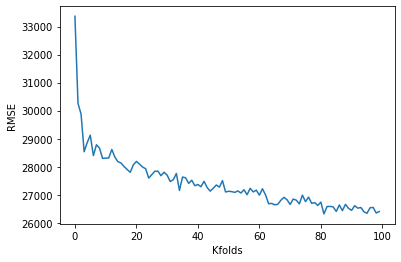

In [22]:
transformed_data = transform_features(data)
final_data = select_features(transformed_data)

results = []
for i in range(100):
    result = train_and_test(final_data, k=i)
    results.append(result)
    
x = [i for i in range(100)]
y = results 
pl = plt.plot(x, y)
plt.xlabel('Kfolds')
plt.ylabel('RMSE')

In [27]:
plt.show()